In [1]:
import sys

In [2]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/20WINTER/CS M146/PSET1/'] 
### ========== TODO : END ========== ###


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from nutil import *

In [6]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [8]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        count = Counter(y)
        total = float(sum(count.values()))
        '''
        self.probabilities_ = dict(count)
        for key in self.probabilities_:
          self.probabilities_[key] /= total
        '''
        n,d = X.shape
        self.probabilities_ = [count[0]/n, count[1]/n]
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n, d = X.shape
        y = np.random.choice(2,n, p=self.probabilities_)
        ### ========== TODO : END ========== ###

        return y


In [9]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [10]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    train_error = 0
    test_error = 0
    f1_score = 0

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    for train_index, test_index in sss.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      Y_train, Y_test = y[train_index], y[test_index]

      clf.fit(X_train, Y_train)
      y_pred_train = clf.predict(X_train)
      y_pred_test = clf.predict(X_test)

      train_error += 1 - metrics.accuracy_score(Y_train, y_pred_train, normalize=True)
      test_error += 1 - metrics.accuracy_score(Y_test, y_pred_test, normalize=True)
      f1_score += metrics.f1_score(Y_test, y_pred_test)
      
    # Calculate the errors
    train_error /= float(ntrials)
    test_error /= float(ntrials)
    f1_score /= float(ntrials)
   
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [11]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- 3-NN training error: 0.153
	-- 5-NN training error: 0.195
	-- 7-NN training error: 0.213
Investigating various classifiers...

    	-- Majority Vote Classifier
    	 training error: 0.240  
    	 test error: 0.240
    	 F1 score: 0.000
    

    	-- Random Classifier
    	 training error: 0.375  
    	 test error: 0.382
    	 F1 score: 0.251
    

    	-- Decision Tree Classifier
    	 training error: 0.000  
    	 test error: 0.205
    	 F1 score: 0.569
    

    	-- 5-NN Classifier
    	 training error: 0.202  
    	 test error: 0.259
    	 F1 score: 0.160
    
Finding the best k...
	-- Best k value: 15


<Figure size 432x288 with 0 Axes>

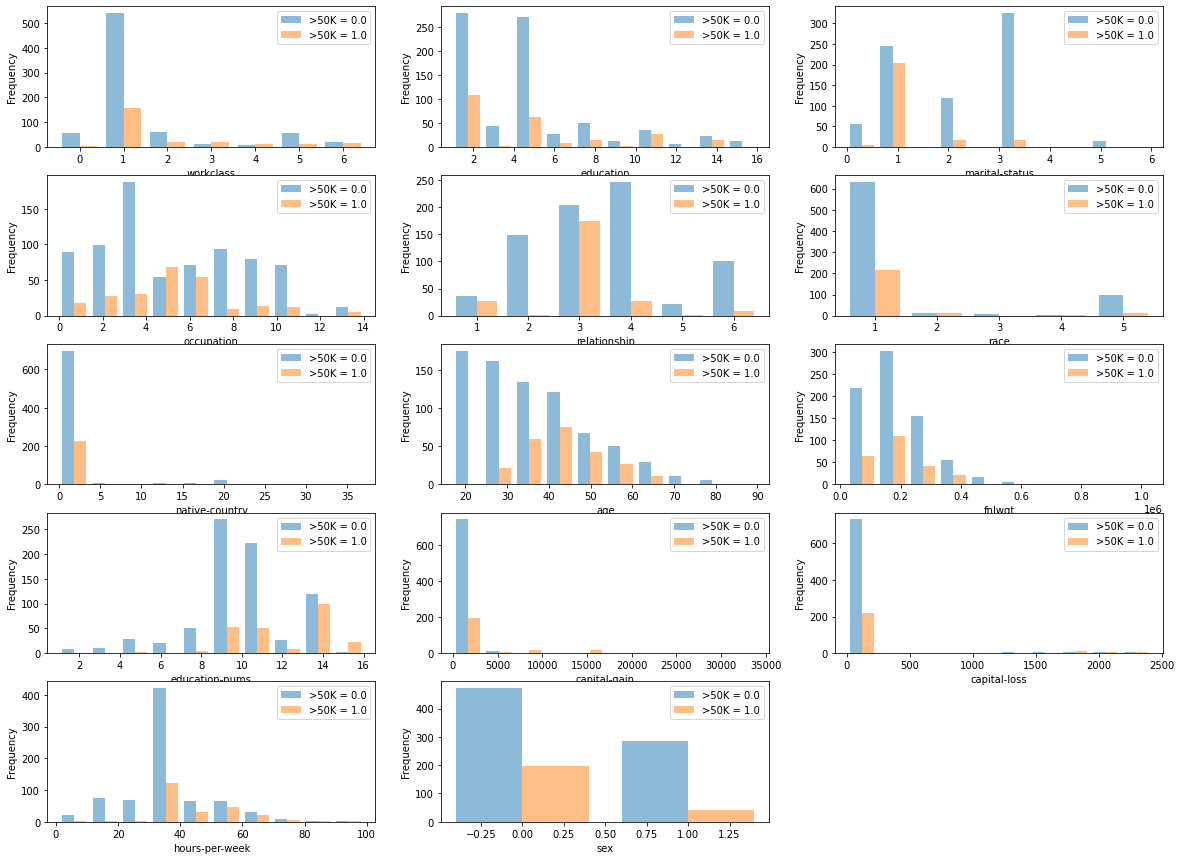

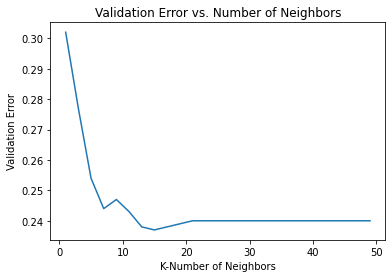

Investigating depths...
	-- Best Depth Limit: 5


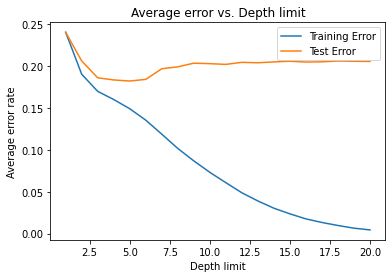

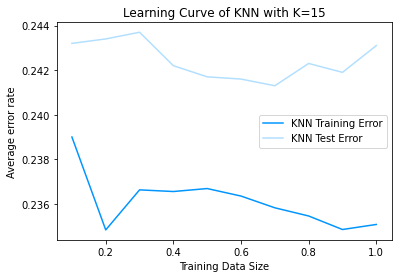

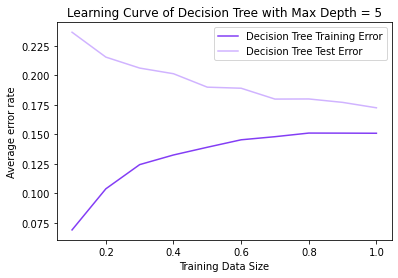

Done


In [16]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file = '/content/drive/My Drive/20WINTER/CS M146/PSET1/adult_subsample.csv'
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    rand_clf = RandomClassifier()
    rand_clf.fit(X, y)
    y_pred = rand_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    decisionTree = DecisionTreeClassifier(criterion="entropy")
    decisionTree.fit(X, y)
    y_pred = decisionTree.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    K3NN_clf = KNeighborsClassifier(n_neighbors=3)
    K3NN_clf.fit(X, y)
    y_pred = K3NN_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- 3-NN training error: %.3f' % train_error)

    K5NN_clf = KNeighborsClassifier(n_neighbors=5)
    K5NN_clf.fit(X, y)
    y_pred = K5NN_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- 5-NN training error: %.3f' % train_error)

    K7NN_clf = KNeighborsClassifier(n_neighbors=7)
    K7NN_clf.fit(X, y)
    y_pred = K7NN_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- 7-NN training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    
    clf = MajorityVoteClassifier()       
    train_error, test_error, f1_score = error(clf, X, y, ntrials=100)
    print('''
    \t-- Majority Vote Classifier
    \t training error: %.3f  
    \t test error: %.3f
    \t F1 score: %.3f
    ''' % (train_error, test_error, f1_score))

    clf = RandomClassifier()      
    train_error, test_error, f1_score = error(clf, X, y, ntrials=100)
    print('''
    \t-- Random Classifier
    \t training error: %.3f  
    \t test error: %.3f
    \t F1 score: %.3f
    ''' % (train_error, test_error, f1_score))

    clf = DecisionTreeClassifier(criterion="entropy")      
    train_error, test_error, f1_score = error(clf, X, y, ntrials=100)
    print('''
    \t-- Decision Tree Classifier
    \t training error: %.3f  
    \t test error: %.3f
    \t F1 score: %.3f
    ''' % (train_error, test_error, f1_score))

    clf = KNeighborsClassifier(n_neighbors=5)     
    train_error, test_error, f1_score = error(clf, X, y, ntrials=100)
    print('''
    \t-- 5-NN Classifier
    \t training error: %.3f  
    \t test error: %.3f
    \t F1 score: %.3f
    ''' % (train_error, test_error, f1_score))
    
    ### ========== TODO : END ========== ###


    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    odd_n = [i for i in range(1,50,2)]
    errors = []
    for k in odd_n:
      clf = KNeighborsClassifier(n_neighbors=k)
      cv_score = cross_val_score(clf, X, y, cv=10) # Running 10-fold cross validation for odd numbers from 1-50
      cv_error = 1 - sum(cv_score)/float(len(cv_score))
      errors.append(cv_error)

    lowest_error = min(errors)
    best_k = odd_n[errors.index(lowest_error)]
    print("\t-- Best k value: %d" % best_k)

    # plot the validation error vs k number of neighbors
    plt.figure()
    plt.plot(odd_n, errors)
    plt.xlabel("K-Number of Neighbors")
    plt.ylabel("Validation Error")
    plt.title("Validation Error vs. Number of Neighbors")
    plt.show()
    ### ========== TODO : END ========== ###


    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    depth_limit = [i for i in range(1,21)]
    train_errors = []
    test_errors = []
    for depth in depth_limit:
      clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
      train_error, test_error, f1_score = error(clf, X, y, ntrials=100)
      train_errors.append(train_error)
      test_errors.append(test_error)
    
    lowest_error = min(test_errors)
    best_depth = depth_limit[test_errors.index(lowest_error)]
    print("\t-- Best Depth Limit: %d" % best_depth)

    # plot the average training error and test error against the depth limit
    plt.figure()
    plt.plot(depth_limit, train_errors, label="Training Error")
    plt.plot(depth_limit, test_errors, label="Test Error")
    plt.xlabel("Depth limit")
    plt.ylabel("Average error rate")
    plt.title("Average error vs. Depth limit")
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes


    splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    KNN_train_errors = [0]*10
    KNN_test_errors = [0]*10
    DT_train_errors = [0]*10
    DT_test_errors = [0]*10

    ntrials = 100
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=0.1, random_state=0)
    knn_clf = KNeighborsClassifier(n_neighbors=best_k)
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for i in range(0,10):
          train_size = splits[i]
          X_train_split = X_train[:int(len(X_train)*train_size)]
          y_train_split = y_train[:int(len(y_train)*train_size)]

          knn_clf.fit(X_train_split, y_train_split)
          y_pred_train = knn_clf.predict(X_train_split)
          y_pred_test = knn_clf.predict(X_test)

          KNN_train_errors[i] += (1 - metrics.accuracy_score(y_train_split, y_pred_train, normalize=True))/ntrials
          KNN_test_errors[i] += (1 - metrics.accuracy_score(y_test, y_pred_test, normalize=True))/ntrials

          dt_clf.fit(X_train_split, y_train_split)
          y_pred_train = dt_clf.predict(X_train_split)
          y_pred_test = dt_clf.predict(X_test)

          DT_train_errors[i] += (1 - metrics.accuracy_score(y_train_split, y_pred_train, normalize=True))/ntrials
          DT_test_errors[i] += (1 - metrics.accuracy_score(y_test, y_pred_test, normalize=True))/ntrials

    # plot decision tree and k-nearest neighbors training/test error against the amount of training data
    plt.figure()
    plt.plot(splits, KNN_train_errors, label="KNN Training Error", color="#0095ff")
    plt.plot(splits, KNN_test_errors, label="KNN Test Error", color="#b3dfff")
    plt.xlabel("Training Data Size")
    plt.ylabel("Average error rate")
    plt.title("Learning Curve of KNN with K=15")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(splits, DT_train_errors, label="Decision Tree Training Error", color="#833df5")
    plt.plot(splits, DT_test_errors, label="Decision Tree Test Error", color="#d0b3ff")
    plt.xlabel("Training Data Size")
    plt.ylabel("Average error rate")
    plt.title("Learning Curve of Decision Tree with Max Depth = 5")
    plt.legend()
    plt.show()
    
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
